In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
from pathos.multiprocessing import ProcessingPool as Pool
from scipy.interpolate import griddata



In [2]:
def cdf(sample, x):
        # Counts how many observations are below or equal to x and normalize
        return np.sum(sample <= x) / len(sample)

In [3]:
def ks_2samp(sample1, sample2):
     # Gets all unique observations
    observations = np.unique(np.concatenate((sample1, sample2)))
    
    # Computes the CDF for both samples at each observation
    cdf_sample1 = np.array([cdf(sample1, x) for x in observations])
    cdf_sample2 = np.array([cdf(sample2, x) for x in observations])

    # Computes the KS statistic
    D_ks = np.max(np.abs(cdf_sample1 - cdf_sample2))

    # Calculates the P-Value based on the two-sided test
    m, n = float(len(sample1)), float(len(sample2))
    #Should this just be m or n if they're the same length?
    en = m * n / (m + n)
    p_value = stats.kstwo.sf(D_ks, np.round(en))
#     print(D_ks, np.sqrt((m + n)/(m * n))*1.36)
    # p_value = stats.kstwo.sf(D_ks, np.round(np.sqrt(en)))

    return {"ks_stat": D_ks, "p_value" : p_value}

### T_E KS test

### Are equal

In [4]:
log_t_e_pbh = np.random.normal(loc = 0, scale = 1, size = 450)
log_t_e_ffp = np.random.uniform(low = -1, high = 1, size = 50)
log_t_e_total_ffp = np.concatenate((log_t_e_pbh, log_t_e_ffp))
log_t_e_total_pbh = np.random.normal(loc = 0, scale = 1, size = 500)

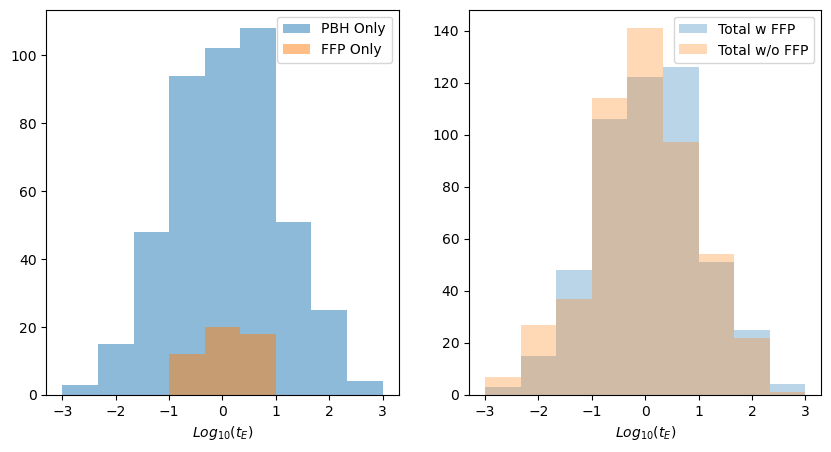

In [5]:
plt.figure(figsize = (10, 5))

plt.subplot(1,2,1)
plt.hist(log_t_e_pbh, bins=np.linspace(-3,3,10), alpha = 0.5, label = "PBH Only")
plt.hist(log_t_e_ffp, bins=np.linspace(-3,3,10), alpha = 0.5, label = "FFP Only")
plt.xlabel(r'$Log_{10} (t_E)$')

plt.legend()

plt.subplot(1,2,2)
plt.hist(log_t_e_total_ffp, bins=np.linspace(-3,3,10), alpha = 0.3, label = "Total w FFP")
plt.hist(log_t_e_total_pbh, bins=np.linspace(-3,3,10), alpha = 0.3, label = "Total w/o FFP")
plt.xlabel(r'$Log_{10} (t_E)$')
plt.legend()
plt.show()

In [6]:
ks = ks_2samp(log_t_e_total_ffp, log_t_e_total_pbh)
print(f"FFP vs No FFP: ks = {ks['ks_stat']:.4f} (p-value = {ks['p_value']:.3e}, are equal = {ks['p_value'] > 0.05})")


FFP vs No FFP: ks = 0.0720 (p-value = 1.426e-01, are equal = True)


### Are not equal

In [7]:
log_t_e_pbh = np.random.normal(loc = 0, scale = 1, size = 300)
log_t_e_ffp = np.random.uniform(low = 1, high = 3, size = 200)
log_t_e_total_ffp = np.concatenate((log_t_e_pbh, log_t_e_ffp))
log_t_e_total_pbh = np.random.normal(loc = 0, scale = 1, size = 500)

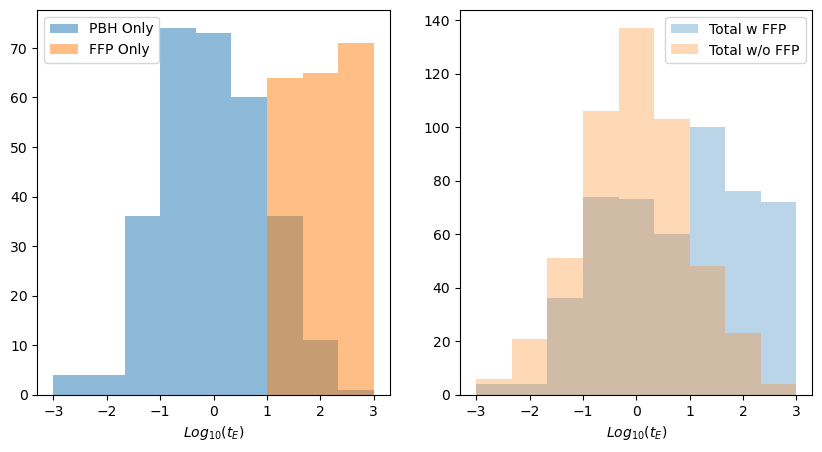

In [8]:
plt.figure(figsize = (10, 5))

plt.subplot(1,2,1)
plt.hist(log_t_e_pbh, bins=np.linspace(-3,3,10), alpha = 0.5, label = "PBH Only")
plt.hist(log_t_e_ffp, bins=np.linspace(-3,3,10), alpha = 0.5, label = "FFP Only")
plt.xlabel(r'$Log_{10} (t_E)$')

plt.legend()

plt.subplot(1,2,2)
plt.hist(log_t_e_total_ffp, bins=np.linspace(-3,3,10), alpha = 0.3, label = "Total w FFP")
plt.hist(log_t_e_total_pbh, bins=np.linspace(-3,3,10), alpha = 0.3, label = "Total w/o FFP")
plt.xlabel(r'$Log_{10} (t_E)$')
plt.legend()
plt.show()

In [9]:
ks = ks_2samp(log_t_e_total_ffp, log_t_e_total_pbh)
print(f"FFP vs No FFP: ks = {ks['ks_stat']:.4f} (p-value = {ks['p_value']:.3e}, are equal = {ks['p_value'] > 0.05})")


FFP vs No FFP: ks = 0.3500 (p-value = 6.995e-28, are equal = False)


### Build a search to compare popsycle generated data to a "real" dataset

In [10]:
#! eventually have to deal with the fact that we're artificially truncating the mass distribution at low M
def sample_ffp_mass(N_ffps: int, p: float = 1.0) -> np.ndarray:
    '''
    Sampling distribution of dn/dM propto M^-2 -> n propto M^-1.
    Using inverse transform sampling of CDF M^-1
    Returns an array of masses following this distribution with length N_ffps
    '''

    #Jupiter is about 1e-3 solar masses
    # return np.ones(N_ffps) * 1e-3

    M_min = 1.e-7
    M_max = 1.e-2
    # alpha = 2 
    alpha = 1 + p
    # Mass PDF M**-(alpha+1)
    # Mass CDF M**-alpha

    M_sample = []
    for i in range(N_ffps):
        newmass = M_min * (1-np.random.random())**(-1/(alpha-1))
        if newmass > M_max:
            newmass = M_max
        M_sample.append(newmass)
    return np.array(M_sample)

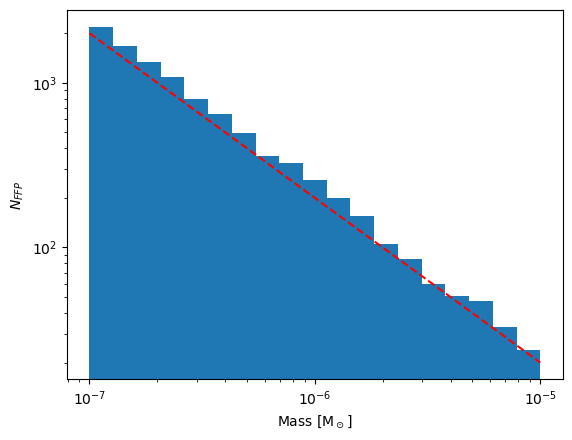

In [11]:
plt.hist(sample_ffp_mass(10000, 1.0), bins=np.logspace(-7, -5, 20))
plt.plot(np.logspace(-7, -5, 100), 2e-4*np.logspace(-7, -5, 100)**(-1), 'r--')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Mass [M$_\odot$]')
plt.ylabel('$N_{FFP}$')
plt.show()

In [12]:
def generate_simulated_data(n_ffp=250, n_pbh=250, m_pbh=5e-7, p=1.1, separate=False):
    # Generate masses for FFPs from a power-law distribution
    m_ffp = sample_ffp_mass(n_ffp, p)

    # Generate distances and velocities for FFPs
    D_ffp = np.random.uniform(low=10, high=100, size=n_ffp)  # replace with actual distribution
    V_ffp = np.random.normal(loc=200, scale=50, size=n_ffp)  # replace with actual distribution

    # Calculate Einstein crossing times for FFPs in hours
    #appendix eq (7) in https://arxiv.org/pdf/1701.02151.pdf
    t_e_ffp = 34 * np.sqrt(m_ffp) * np.sqrt(D_ffp) / V_ffp / 24

    # Generate distances and velocities for PBHs
    D_pbh = np.random.uniform(low=10, high=100, size=n_pbh)  # replace with actual distribution
    V_pbh = np.random.normal(loc=200, scale=50, size=n_pbh)  # replace with actual distribution

    # Calculate Einstein crossing times for PBHs in hours
    t_e_pbh = 34 * np.sqrt(m_pbh) * np.sqrt(D_pbh) / V_pbh / 24

    # Combine the data
    simulated_data = np.concatenate((t_e_ffp, t_e_pbh))

    if separate:
        return t_e_ffp, t_e_pbh
    return simulated_data


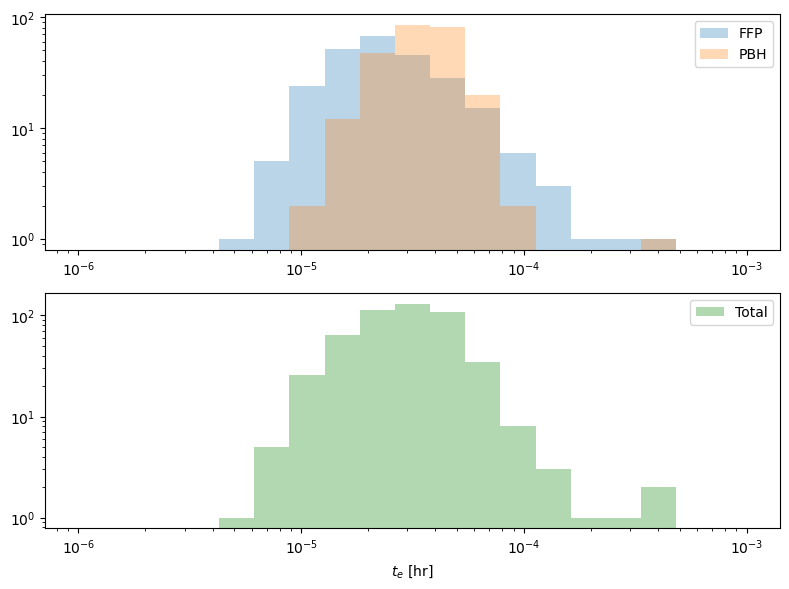

In [13]:
plt.figure(figsize=(8, 6))
t_e_ffp, t_e_pbh = generate_simulated_data(separate=True)
bins = np.logspace(-6, -3, 20)
plt.subplot(2, 1, 1)
plt.hist(t_e_ffp, bins=bins, label='FFP', alpha=0.3)
plt.hist(t_e_pbh, bins=bins, label='PBH', alpha=0.3)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.subplot(2, 1, 2)

t_e_tot = np.concatenate((t_e_ffp, t_e_pbh))

plt.hist(t_e_tot, bins=bins, label='Total', alpha=0.3, color='green')
plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'$t_e$ [hr]')
plt.legend()

plt.tight_layout()
plt.show()

I'm a bit concerned that very large values of p, (>1.3) are close to degenerate with monochromatic spectrum

In [14]:
def generate_simulations(f_pbh_values, n_events=500, m_pbh=5e-7, p=1.1):
    # Generate multiple simulated datasets for varying fractions of FFP and PBH
    simulations = []
    for f_pbh in f_pbh_values:
        f_ffp = 1 - f_pbh
        n_ffp = round(f_ffp*n_events)
        n_pbh = round(f_pbh*n_events)
        simulations.append(generate_simulated_data(n_ffp, n_pbh, m_pbh, p))
    return simulations

def compare_simulations_to_observed(observed, simulations, ks_2samp):
    # Initialize an empty list to store the results
    results = []
    
    # For each simulated dataset...
    for simulated in simulations:
        # Compute the K-S statistic and p-value
        result = ks_2samp(observed, simulated)
        
        # Append the result to the list
        results.append(result)
    
    # Find the simulated dataset with the smallest K-S statistic (i.e., the closest to the observed) and the index of that dataset
    min_ks_stat = min(results, key=lambda result: result["ks_stat"])
    min_ks_stat_index = results.index(min_ks_stat)
    
    return min_ks_stat, min_ks_stat_index


In [15]:
#generate random parameters for the "observed" data
N_events = 500
f_pbh_obs = 0.5
n_pbh_obs = round(N_events * f_pbh_obs)
n_ffp_obs = N_events - n_pbh_obs
m_pbh_obs = 10**np.random.uniform(-6, -3)
p_obs = np.random.uniform(0.6, 1.4)

observed_placeholder = generate_simulated_data(n_pbh=n_pbh_obs, n_ffp=n_ffp_obs, m_pbh=m_pbh_obs, p=p_obs)

print(m_pbh_obs, p_obs, f_pbh_obs)

5.1543553508140336e-06 1.1990927781924992 0.5


In [16]:
# Define the range of parameters to scan over
m_pbh_values = np.logspace(-6, -3, 30)
p_values = np.linspace(0.5, 1.5, 30)
# f_pbh_values = np.linspace(0.0, 1.0, 10)
f_pbh_fixed = 0.5

# def process_params(params):
#     m_pbh, p, f_pbh = params
#     # Generate simulations
#     simulations = generate_simulations(f_pbh_values, m_pbh=m_pbh, p=p)

#     # Compare each simulated dataset to the observed dataset
#     min_ks_stat, min_ks_stat_index = compare_simulations_to_observed(observed_placeholder, simulations, ks_2samp)

#     # Return the results
#     return (m_pbh, p, f_pbh, min_ks_stat, min_ks_stat_index)

def process_params(params):
    m_pbh, p = params
    # Generate simulations
    simulations = generate_simulations([f_pbh_fixed], m_pbh=m_pbh, p=p)

    # Compare each simulated dataset to the observed dataset
    min_ks_stat, min_ks_stat_index = compare_simulations_to_observed(observed_placeholder, simulations, ks_2samp)

    # Return the results
    return (m_pbh, p, f_pbh_fixed, min_ks_stat, min_ks_stat_index)

In [17]:
# Define the parameter space
# params = [(m_pbh, p, f_pbh) for m_pbh in m_pbh_values for p in p_values for f_pbh in f_pbh_values]
params = [(m_pbh, p) for m_pbh in m_pbh_values for p in p_values]

# this only works when run the first time. Otherwise have to restart notebook
with Pool() as pool:
    results = pool.map(process_params, params)

# Convert the results to a dictionary
results = {(m_pbh, p, f_pbh_fixed): (min_ks_stat, min_ks_stat_index) for m_pbh, p, f_pbh_fixed, min_ks_stat, min_ks_stat_index in results}

In [18]:
# Find the parameters (M_PBH, p) that yield the smallest K-S statistic
best_params = min(results, key=lambda x: results[x][0]["ks_stat"])

# Extract the corresponding K-S statistic, p-value, and index
best_ks_stat, best_ks_stat_index = results[best_params]

print(f"ks = {best_ks_stat['ks_stat']:.4f} (p-value = {best_ks_stat['p_value']:.3e}, are equal = {best_ks_stat['p_value'] > 0.05})")

m_pbh_best, p_best, f_pbh_best = best_params

# Print the best result
print(f"Best parameters: M_PBH = {m_pbh_best:.2e}, p = {p_best:.2f}, f_PBH = {f_pbh_best:.2%}")
# Actual parameters
print(f"Actual parameters: M_PBH = {m_pbh_obs:.2e}, p = {p_obs:.2f}, f_PBH = {f_pbh_obs:.2%}")

ks = 0.0320 (p-value = 9.528e-01, are equal = True)
Best parameters: M_PBH = 5.30e-06, p = 1.05, f_PBH = 50.00%
Actual parameters: M_PBH = 5.15e-06, p = 1.20, f_PBH = 50.00%


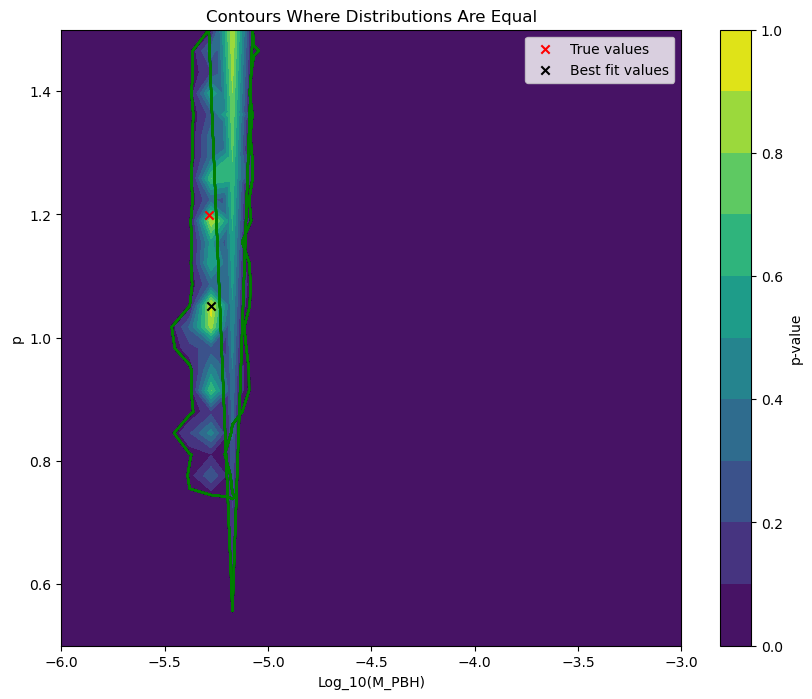

In [21]:
# Get the M_PBH, p, and f_PBH values and the corresponding p-values
m_pbh_values = [np.log10(params[0]) for params in results.keys()]
p_values = [params[1] for params in results.keys()]
p_values_results = [res[0]['p_value'] for res in results.values()]

# Prepare the grid for contour plot
m_pbh_grid, p_grid = np.meshgrid(m_pbh_values, p_values)

# Interpolate the p-values onto the grid
p_values_grid = griddata((m_pbh_values, p_values), p_values_results, (m_pbh_grid, p_grid), method='cubic')

# Plot the contours where p_value > 0.05 (distributions are considered equal)
plt.figure(figsize=(10, 8))
contour = plt.contourf(m_pbh_grid, p_grid, p_values_grid, levels=10)
plt.colorbar(contour, label='p-value')
contour = plt.contour(m_pbh_grid, p_grid, p_values_grid, colors='green', levels=[-1,0.05], alpha=0.5)


# Plot the true values of the observed parameters
plt.scatter(np.log10(m_pbh_obs), p_obs, color='red', marker='x', label='True values')

# Plot the best fit values of the observed parameters
plt.scatter(np.log10(m_pbh_best), p_best, color='black', marker='x', label='Best fit values')

# Label the axes
plt.xlabel('Log_10(M_PBH)')
plt.ylabel('p')
plt.legend()
# Title the plot
plt.title('Contours Where Distributions Are Equal')

plt.show()

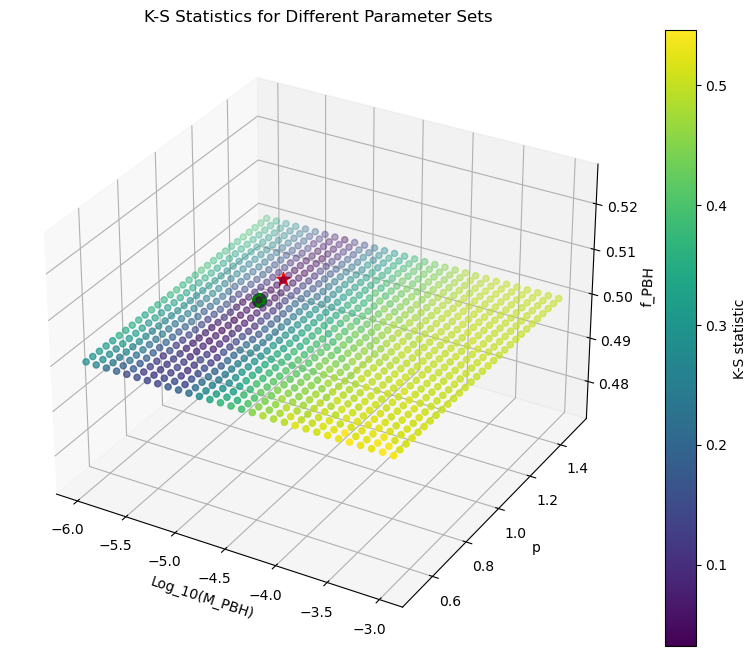

In [20]:
# Get the M_PBH, p, and f_PBH values and the corresponding K-S statistics
M_PBH_values = [np.log10(params[0]) for params in results.keys()]
p_values = [params[1] for params in results.keys()]
f_PBH_values = [params[2] for params in results.keys()]
ks_stats = [res[0]['ks_stat'] for res in results.values()]

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the data
sc = ax.scatter(M_PBH_values, p_values, f_PBH_values, c=ks_stats, cmap='viridis')

# plot the true values
ax.scatter(np.log10(m_pbh_obs), p_obs, f_pbh_obs, c='red', s=100, marker='*')

# plot the best fit values
ax.scatter(np.log10(m_pbh_best), p_best, f_pbh_best, c='green', s=100, marker='o')

# Add colorbar
plt.colorbar(sc, label='K-S statistic')

# Label the axes
ax.set_xlabel('Log_10(M_PBH)')
ax.set_ylabel('p')
ax.set_zlabel('f_PBH')

# Title the plot
ax.set_title('K-S Statistics for Different Parameter Sets')

plt.show()
